In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

In [2]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !nvidia-smi
    TF_CPP_MIN_LOG_LEVEL=2

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # get data
    !wget --no-check-certificate \
        https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
        -O /tmp/Features.csv
        
    data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    path_of_file = '../Data/single_feature.csv'
    data = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')


Running on CoLab
Tue Oct 20 15:33:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                       

In [12]:
def split_sequences_multivariate(sequences, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    #n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    #sequences = np.concatenate([X_train, X_train[:,0].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    #print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

# split a multivariate sequence into samples
def multi_step_output(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def plot_distribution_error(model, train_X, test_X, train_y, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle('Distributions of Prediction and True Values', y=1.02, fontsize=13.5)
    sns.distplot(a=train_predictions.flatten(), ax=ax1, label='Prediction')
    sns.distplot(a=train_y.flatten(), ax=ax1, label= 'True')
    sns.distplot(a=test_predictions.flatten(), ax=ax2, label='Prediction')
    sns.distplot(a=test_y.flatten(), ax=ax2, label='True')
    plt.legend()
    plt.tight_layout()

def get_errors(model, train_X, test_X, train_y, test_y):
    
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    MAE_train = abs(train_predictions - train_y).mean()
    MAE_test = abs(test_predictions - test_y).mean()
    if train_y.shape[1] == 3:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1))
        mse_test = mean_squared_error(test_y, test_predictions)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(test_y, test_predictions)
    else:
        mae_overall_train = abs(train_predictions-train_y).mean(axis=(1,2))
        mae_overall_test = abs(test_predictions-test_y).mean(axis=(1,2))
        mse_test = mean_squared_error(test_y.reshape(-1,3), test_predictions.reshape(-1,3))
        r2_test = r2_score(test_y.reshape(-1,3), test_predictions.reshape(-1,3)) 

    rmse_test = np.sqrt(mse_test)
    return MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test

def plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle):
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,4))
    fig.suptitle(suptitle, y=1.02, fontsize=16.5)
    
    ax1.plot(mae_overall_train, label='MAE Train')
    ax1.set_title('MAE Train={}'.format(MAE_train))
    ax2.plot(mae_overall_test, label='MAE Test', color='teal')
    ax2.set_title('MAE Test={}'.format(MAE_test))
    fig.legend(loc='upper right')
    plt.tight_layout()

def plot_lstm(model, X, y, feature_index=0):

    prediction = model.predict(X)
    if prediction.shape[-1] == 1:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    else:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X)[:,feature_index].reshape(-1,1),
                                                     y[:,feature_index].reshape(-1,1)), axis=1), columns=['Prediction', 'True'])
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse_test)
    r2 = r2_score(y, prediction)

    fig, ax1 = plt.subplots(1,1,figsize=(14,4))
    pred_df.plot(ax=ax1)
    plt.legend(loc='upper left')
    plt.title('Prediction and Truth rmse = {}, r2 score = {}'.format(np.round(rmse,4), np.round(r2,4)))    
    plt.tight_layout()

def plot_single_seq(model, X, y, feature_index=0):

  prediction = model.predict(X)[:,7,:]
  y = y[:,7,:]
  pred_df = pd.DataFrame(data= np.column_stack((prediction.reshape(-1,3)[:,feature_index],
                                                y.reshape(-1,3)[:,feature_index])),
                          columns=['Prediction', 'True'])
    
  mse = mean_squared_error(y.reshape(-1,3), prediction.reshape(-1,3))
  rmse = np.sqrt(mse)
  r2 = r2_score(y.reshape(-1,3), prediction.reshape(-1,3)) 


  fig, ax1 = plt.subplots(1,1,figsize=(14,4))
  pred_df.plot(ax=ax1)
  plt.legend(loc='upper left')
  plt.title('Prediction and Truth rmse = {}, r2 score = {}'.format(np.round(rmse,4), np.round(r2,4)))    
  plt.tight_layout()
    
def plot_predictions(model, train_X, test_X, train_y, test_y):
    train_predictions = model.predict(train_X)
    test_predictions = model.predict(test_X)
    
    data_final = dict(train_pred=train_predictions, train_true=train_y,
                      test_pred=test_predictions, test_true=test_y)

    # Number of time steps in the future, as increases the accuracy decreases
    ith_timestep = 7

    for lb in ['train', 'test']:   
        fig, axx = plt.subplots(3,1,figsize=(18,9))
        for i, x_lbl, clr,axi in zip([0, 1, 2], ['Temperature', 'VMPPT','VPanel'], ['salmon', 'teal','darkblue'], axx):
            axi.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='-', color='r', label='pred '+x_lbl)
            axi.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
            axi.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
        fig.suptitle('({}): {}th time step in all samples'.format(lb, ith_timestep), y=1.02,fontsize=15)
        plt.tight_layout()

def train_model(model, train_X, train_y, callbacks, epochs=100, batch_size=256, patience=5, verbose=1, validation_split=0.25):

  if verbose==0:
    print('Training model')
  history = model.fit(train_X, train_y,
                      validation_split=validation_split, 
                      epochs=epochs, verbose=verbose,
                      callbacks=[callbacks], 
                      batch_size=batch_size)
  return history

class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, mae=0.03):
    super(myCallback, self).__init__()
    self.mae = mae

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae') <= self.mae):
      print("\nReached 0.03 mae so cancelling training!")
      self.model.stop_training = True

def forecast_att(model, train_X, train_y, forecast_range=100):

  n_timesteps_in = train_X.shape[1]
  n_timesteps_out = train_y.shape[1]
  n_features = train_X.shape[2]
  
  # first set of samples

  batch = train_X[-1, :, :]
  predictions_forecast = batch
  # future timesteps to forcast times X horizon timesteps
  for i in range(forecast_range):
    one_step_pred = model.predict(batch.reshape(1, n_timesteps_in, n_features))
    batch = np.concatenate([batch[n_timesteps_out:], one_step_pred.reshape(n_timesteps_out, n_features)], axis=0)
    predictions_forecast = np.row_stack([predictions_forecast, one_step_pred.reshape(n_timesteps_out, n_features)])

  fig, axx = plt.subplots(3, 1, figsize=(18,7))

  forecast = np.concatenate([train_y[:, n_timesteps_out-1, :], predictions_forecast], axis=0)
  forecast[:train_y.shape[0]] = None
  axx[0].plot(train_y[:, 0, 0])
  axx[0].plot(forecast[:,0])
  axx[1].plot(train_y[:, 0, 1])
  axx[1].plot(forecast[:,1])
  axx[2].plot(train_y[:, 0, 2])
  axx[2].plot(forecast[:,2])
  plt.tight_layout()

In [42]:
### MODELS

def Model_recurrent(units, input_shape, dropout=0.2, LSTM=True):
  tf.keras.backend.clear_session()
  model = tf.keras.models.Sequential()

  if LSTM==False:
    model.add(tf.keras.layers.GRU(units=units, dropout=0.2, return_sequences=True, input_shape=input_shape)) 
    model.add(tf.keras.layers.GRU(units=units, input_shape=input_shape,
                                      return_sequences=False, dropout=dropout))
  else:
    model.add(tf.keras.layers.LSTM(units=units, input_shape=input_shape,
                                      return_sequences=True, dropout=dropout))
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=False,
                                   dropout=dropout))
    
  #model_LSTM.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(n_features))
  return model

def Model_dnn(units, input_shape, dropout=0.2):
  tf.keras.backend.clear_session()
  model = Sequential()
  #model.add(tf.keras.layers.Reshape(input_shape, input_shape=(input_shape,)))
  model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=input_shape))
  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=input_shape[1]))
  return model

def Model_cnn(input_shape, units=128, filters=64, kernel_size=3, dropout=0.2, LSTM=False):
  tf.keras.backend.clear_session()
  model = tf.keras.models.Sequential()

  if LSTM==False:
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, input_shape=input_shape,
                                     activation='relu')) 
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
  else:
    model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, input_shape=input_shape,
                                     activation='relu'))
    model.add(tf.keras.layers.LSTM(units=units, input_shape=input_shape,
                                      return_sequences=False, dropout=dropout))
    #model.add(tf.keras.layers.LSTM(units=units, return_sequences=False,
    #                               dropout=dropout))
    
  #model_LSTM.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(n_features))
  return model

def Model_Seq(n_hidden, input_shape, output_shape, dropout):
  
  input_train = Input(shape=input_shape)
  output_train = Input(shape=output_shape)

  encoder_last_h1, encoder_last_h2, encoder_last_c = \
  tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=dropout,
                       return_sequences=False,
                       return_state=True)(input_train)

  # Batch normalisation is added because we want to avoid gradient
  # explosion caused by the activation function ELU in the encoder.
  encoder_last_h1 = BatchNormalization(momentum=0.9)(encoder_last_h1)
  encoder_last_c = BatchNormalization(momentum=0.9)(encoder_last_c)

  # Create copies of las hidden state
  decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)

  # nitial_state: List of initial state tensors to be passed to the first call of the cell 
  #(optional, defaults to None which causes creation of zero-filled initial state tensors).
  # In this case initial state is the output from encoder
  decoder = tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=dropout,
                                return_state=False,
                                return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

  out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
  model = tf.keras.Model(inputs=input_train, outputs=out)
  return model

Lenght of Data 14688
Lenght of Train 11750


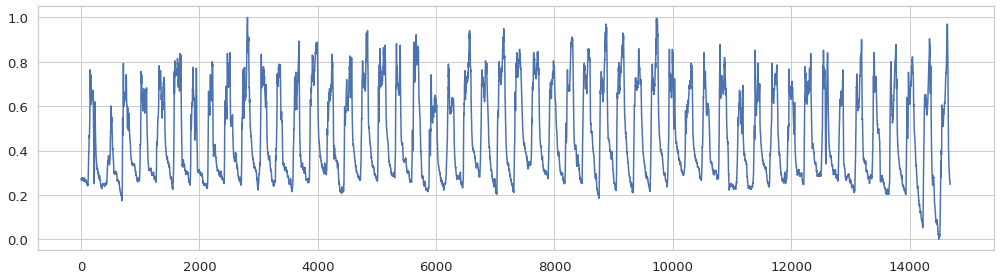

In [5]:
# The data is higly irregular so let's resample it to 10 min and take the mean
resampled = data.resample('5Min').mean()
resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = resampled[init_date:end_date]

train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

fig, ax1 = plt.subplots(1,1, figsize=(14,4))
ax1.plot(normalized_train[:,0])
plt.tight_layout()

# LSTM


Training model
Mean Absolute Error in Testing  0.05693241720509099
Mean Squared Error in Testing  0.008144967517027006
R2 Score in Testing  0.9195089357885786
Root Mean Squared Error in Testing  0.09024947377700884


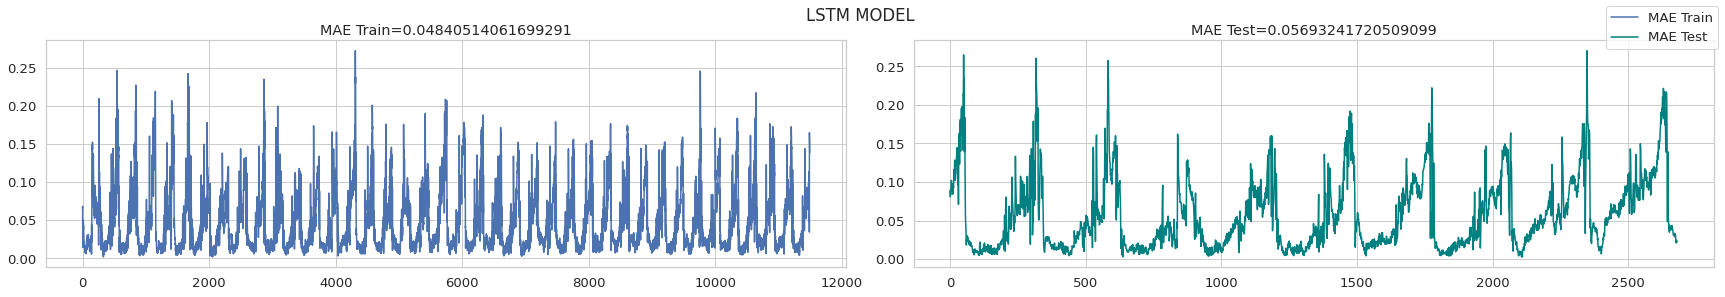

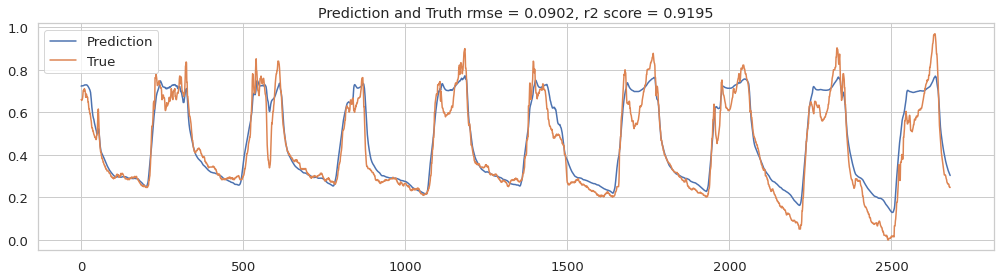

In [50]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 32
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_lstm = Model_recurrent(units=n_hidden, input_shape=(n_timesteps_in, n_features), dropout=0.3)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_lstm = train_model(model_lstm, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_lstm_df = pd.DataFrame(history_lstm.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_lstm, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='LSTM MODEL')

plot_lstm(model_lstm, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# GRU

Training model
Mean Absolute Error in Testing  0.06372382362712636
Mean Squared Error in Testing  0.009111767792548414
R2 Score in Testing  0.916938215932297
Root Mean Squared Error in Testing  0.09545558020644164


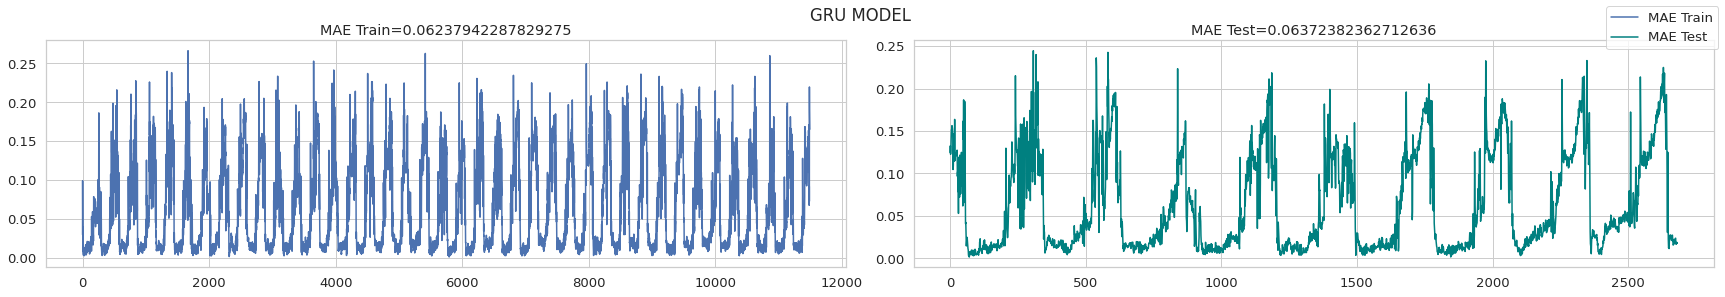

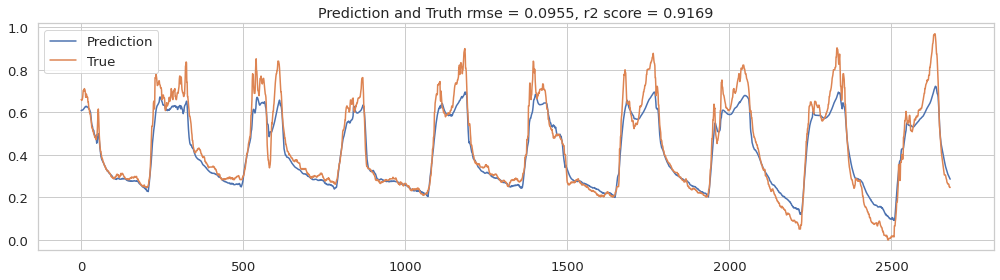

In [18]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_gru = Model_recurrent(units=n_hidden, input_shape=(n_timesteps_in, n_features),
                            dropout=0.2, LSTM=False)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_gru.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_gru = train_model(model_gru, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_gru_df = pd.DataFrame(history_gru.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_gru, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='GRU MODEL')

plot_lstm(model_gru, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# CNN

Training model
Mean Absolute Error in Testing  0.08850962027917551
Mean Squared Error in Testing  0.014021365879830902
R2 Score in Testing  0.8653127272004572
Root Mean Squared Error in Testing  0.11841184856183481


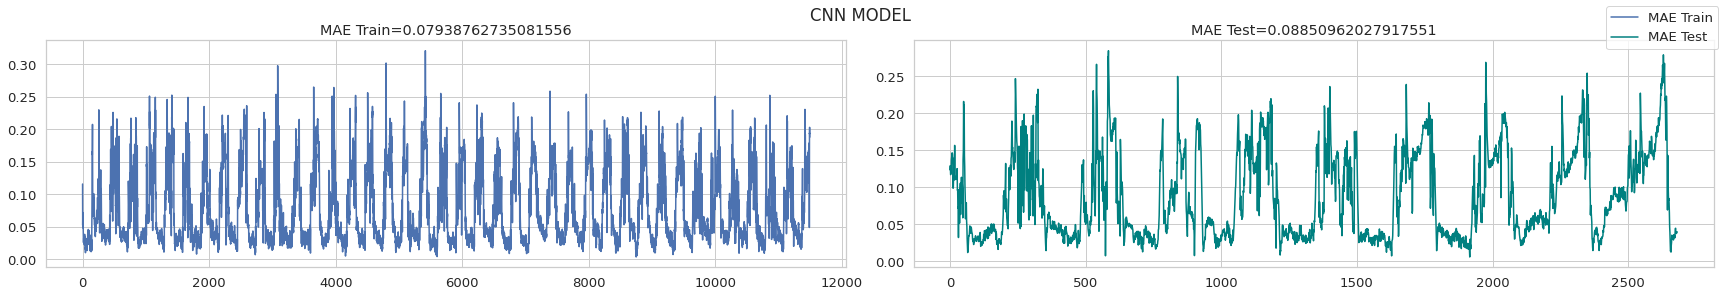

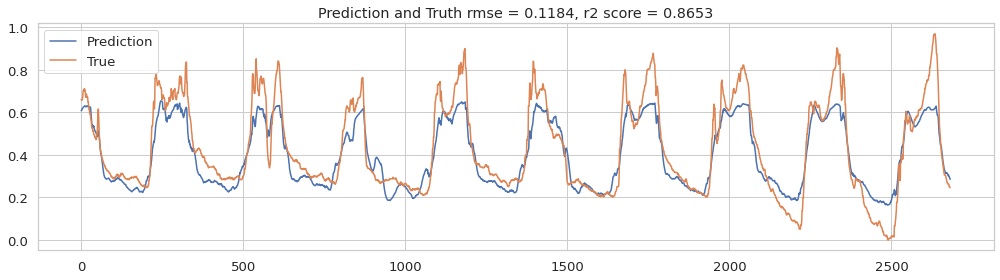

In [34]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_cnn = Model_cnn(input_shape=(n_timesteps_in, n_features), filters=64,
                      kernel_size=3, dropout=0.2, LSTM=False)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_cnn.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_cnn = train_model(model_cnn, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_cnn_df = pd.DataFrame(history_cnn.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_cnn, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='CNN MODEL')

plot_lstm(model_cnn, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# DNN

Training model
Mean Absolute Error in Testing  0.09197533192827982
Mean Squared Error in Testing  0.01395757867454999
R2 Score in Testing  0.8574183520798747
Root Mean Squared Error in Testing  0.11814219684156034


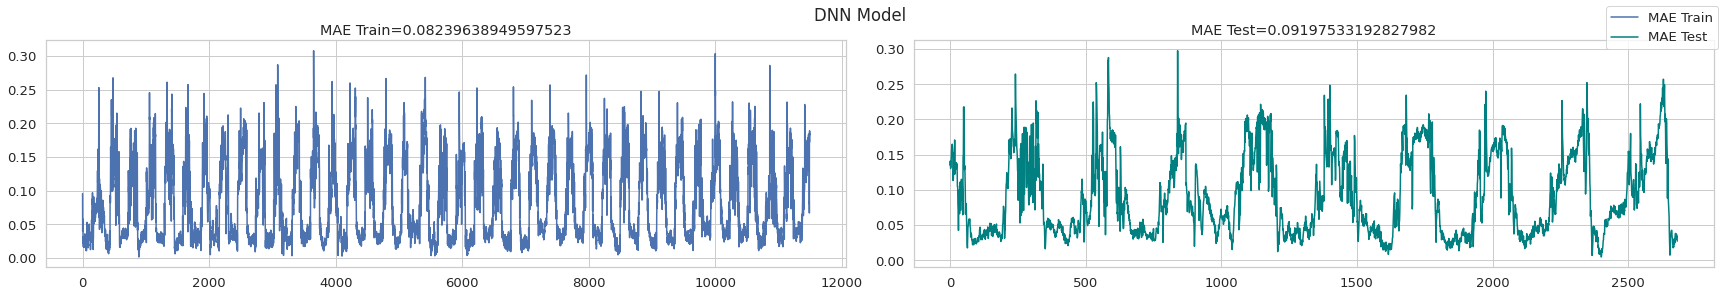

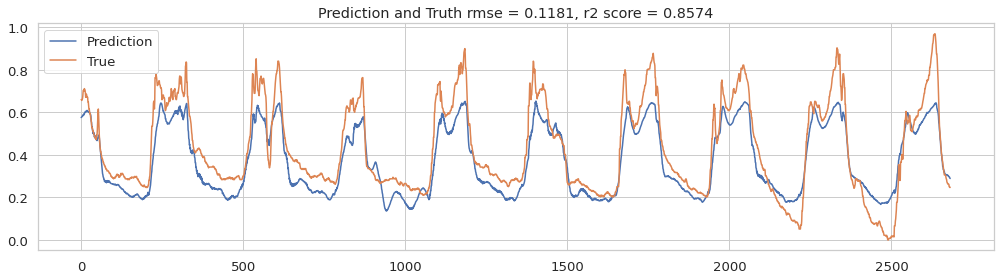

In [20]:
n_timesteps_in = 256
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

model_dnn = Model_dnn(units=64, input_shape=(n_timesteps_in, n_features))

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_dnn.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_dnn = train_model(model_dnn, train_X, train_y, callbacks=early_stop,
                           epochs=100, batch_size=256, patience=5, verbose=0)
history_dnn_df = pd.DataFrame(history_dnn.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_dnn, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='DNN Model')

plot_lstm(model_dnn, test_X, test_y, feature_index=0)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# Seq to Seq

Epoch 1/100
34/34 [==============================] - 20s 599ms/step - loss: 2.2972 - mae: 0.2510 - val_loss: 0.0678 - val_mae: 0.1877
Epoch 2/100
34/34 [==============================] - 20s 588ms/step - loss: 0.0130 - mae: 0.0757 - val_loss: 0.0425 - val_mae: 0.1433
Epoch 3/100
34/34 [==============================] - 20s 583ms/step - loss: 0.0096 - mae: 0.0625 - val_loss: 0.0177 - val_mae: 0.0942
Epoch 4/100
34/34 [==============================] - 20s 591ms/step - loss: 0.0083 - mae: 0.0570 - val_loss: 0.0273 - val_mae: 0.1106
Epoch 5/100
34/34 [==============================] - 20s 582ms/step - loss: 0.0077 - mae: 0.0540 - val_loss: 0.0334 - val_mae: 0.1240
Epoch 6/100
34/34 [==============================] - 20s 600ms/step - loss: 0.0070 - mae: 0.0506 - val_loss: 0.0216 - val_mae: 0.1002
Mean Absolute Error in Testing  0.09999608973843249
Mean Squared Error in Testing  0.021161755874681526
R2 Score in Testing  0.8120417529005789
Root Mean Squared Error in Testing  0.14547080763741

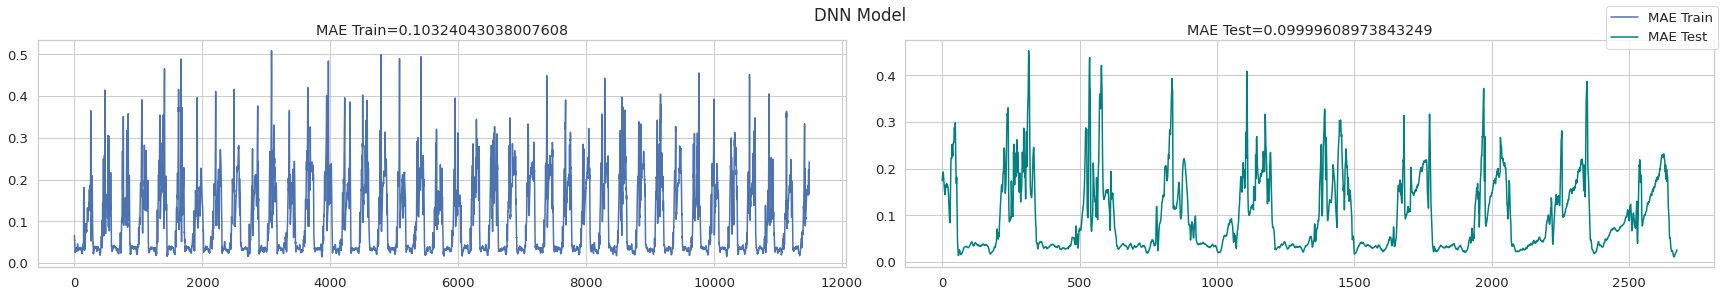

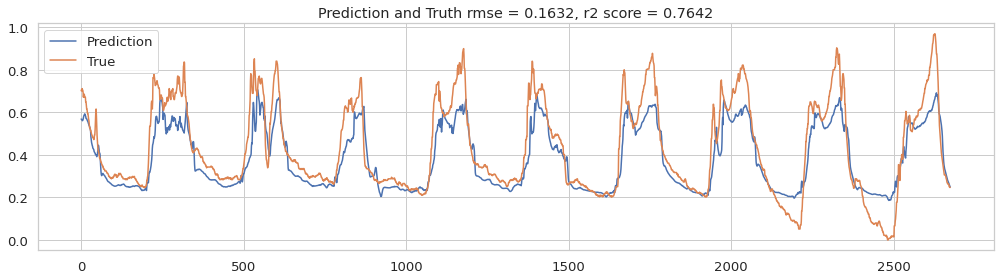

In [43]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.keras.backend.clear_session()

n_timesteps_in = 256
n_timesteps_out = 8
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

model_seq = Model_Seq(n_hidden=128, input_shape=(n_timesteps_in, n_features),
                  output_shape=(n_timesteps_out, n_features), dropout=0.2)

optimizer = tf.keras.optimizers.Adam(lr=0.01)
model_seq.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_seq = train_model(model_seq, train_X, train_y, callbacks=early_stop,
                          epochs=100, verbose=1)

history_seq_df = pd.DataFrame(history_seq.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_seq, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='DNN Model')

plot_single_seq(model_seq, test_X, test_y)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# Attention

In [8]:
def Model_Attention(n_hidden, input_shape, output_shape, dropout):

  input_train = Input(shape=input_shape)
  output_train = Input(shape=output_shape)

  encoder_stack_h, encoder_last_h, encoder_last_c = \
  tf.keras.layers.LSTM(n_hidden, activation='tanh', 
                      return_sequences=True,
                      return_state=True)(input_train)

  #encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
  #encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

  # Repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.
  decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)

  decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh', return_state=False,
                                        return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

  # Alignment Score is Dot Product in Luong Attention
  attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
  attention = tf.keras.layers.Activation('softmax', name='Softmax')(attention)
  context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
  #context = BatchNormalization(momentum=0.6)(context)
  # Now we concat the context vector and stacked hidden states of decoder, 
  # and use it as input to the last dense layer.
  decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
  out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)

  model = tf.keras.models.Model(inputs=input_train, outputs=out)
  
  return model

Training model
Mean Absolute Error in Testing  0.04350188819855658
Mean Squared Error in Testing  0.007056916887842962
R2 Score in Testing  0.9346452299032079
Root Mean Squared Error in Testing  0.08400545748844514


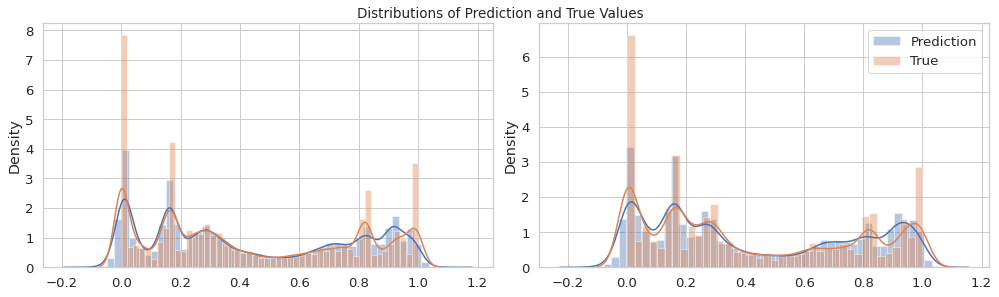

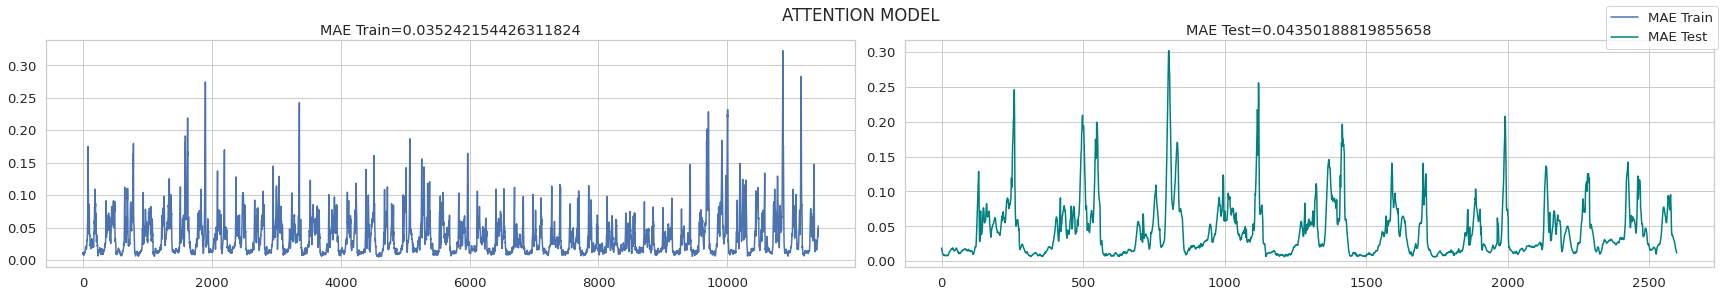

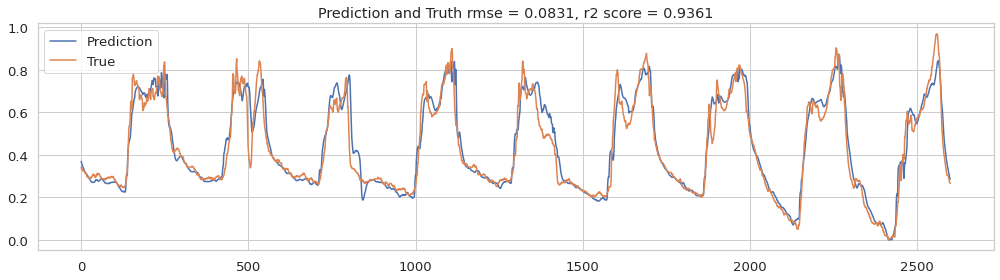

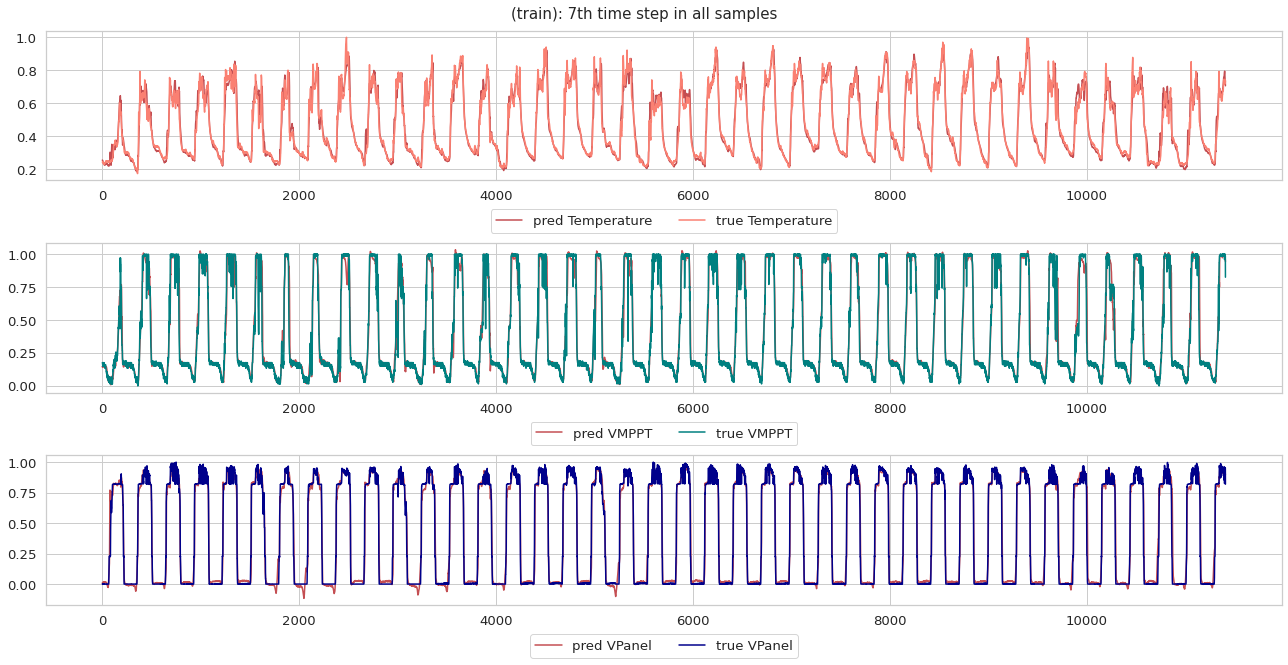

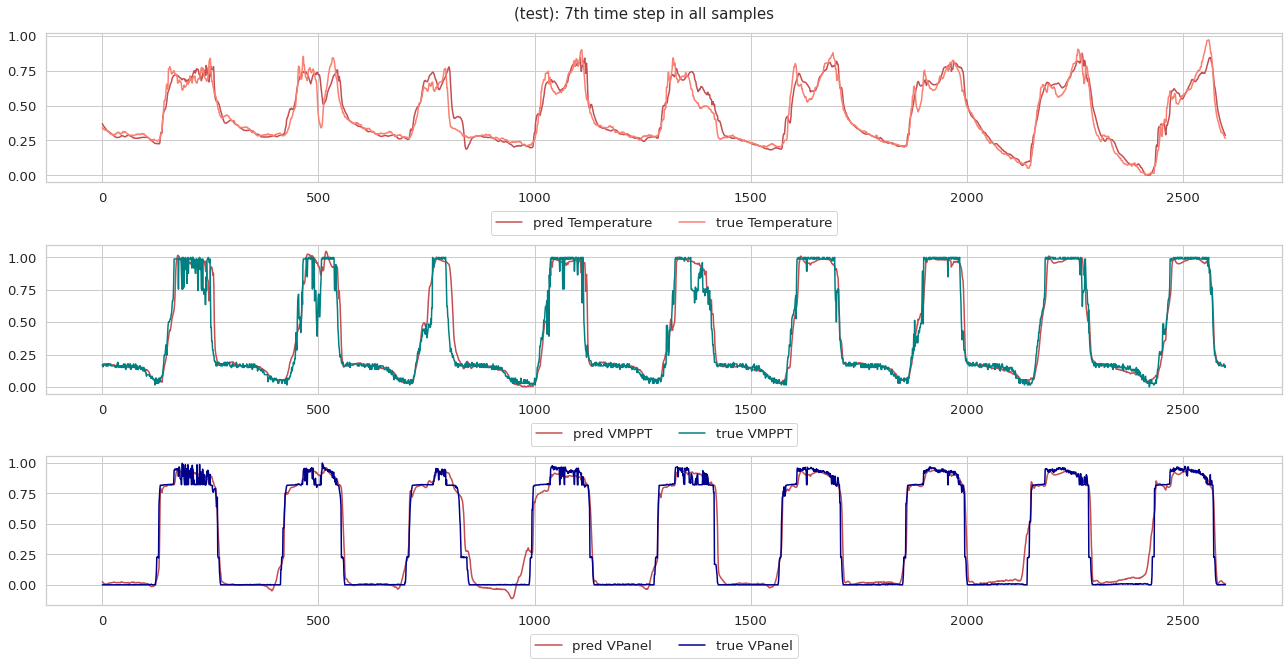

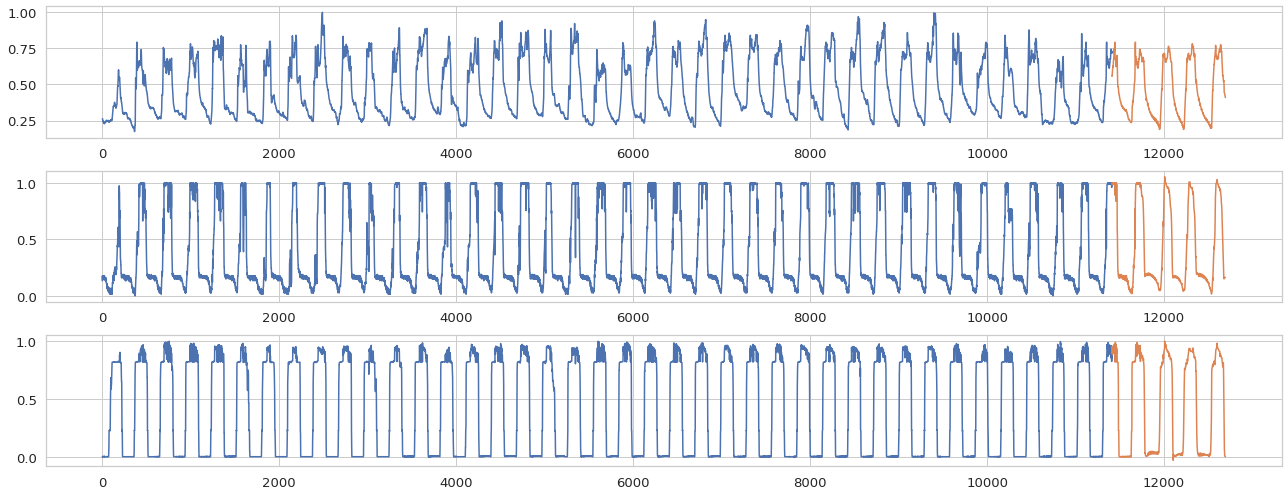

In [76]:
tf.keras.backend.clear_session()

n_timesteps_in = 324
n_timesteps_out = 16
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

model_att = Model_Attention(n_hidden=n_hidden, input_shape=(n_timesteps_in, n_features),
                            output_shape=(n_timesteps_out, n_features), dropout=0.2)

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_att.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
#model.summary()

callback = myCallback(mae=0.032)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)

history_att = train_model(model_att, train_X, train_y, epochs=epochs,
                      batch_size=batch_size, patience=5,
                      validation_split=0.20, verbose=0,
                      callbacks=callback)

history_df = pd.DataFrame(history_att.history, columns=['mae', 'val_mae'])

plot_distribution_error(model_att, train_X, test_X, train_y, test_y)

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_att, train_X, test_X, train_y, test_y)

plot_mae_overall(MAE_train, MAE_test, mae_overall_train, mae_overall_test, suptitle='ATTENTION MODEL')
plot_single_seq(model_att, test_X, test_y)

plot_predictions(model_att, train_X, test_X, train_y, test_y)

forecast_att(model_att, train_X, train_y, forecast_range=60)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# Overfitted Attention


In [ ]:
tf.keras.backend.clear_session()

n_timesteps_in = 256
n_timesteps_out = 8
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

model_att = Model_Attention(n_hidden=n_hidden, input_shape=(n_timesteps_in, n_features),
                            output_shape=(n_timesteps_out, n_features), dropout=0.2)

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_att.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
#model.summary()

callback = myCallback(mae=0.030)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)

history_att = train_model(model_att, train_X, train_y, epochs=epochs,
                      batch_size=batch_size, patience=5,
                      validation_split=0.20, verbose=0,
                      callbacks=callback)

history_df = pd.DataFrame(history_att.history, columns=['mae', 'val_mae'])

MAE_train, MAE_test, mae_overall_train, mae_overall_test, mse_test, r2_test, rmse_test = \
get_errors(model_att, train_X, test_X, train_y, test_y)

print('Mean Absolute Error in Testing ',MAE_test)
print('Mean Squared Error in Testing ',mse_test)
print('R2 Score in Testing ',r2_test)
print('Root Mean Squared Error in Testing ',rmse_test)

# Comparing Models

In [62]:
n_timesteps_in = 256
n_timesteps_out = 8
n_features = 3
n_hidden = 128
epochs = 100
batch_size = 256

feature_index = 0

# Baseline models
train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=n_timesteps_in)
test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=n_timesteps_in)

prediction_lstm = model_lstm.predict(test_X)
prediction_gru = model_gru.predict(test_X)
prediction_cnn = model_cnn.predict(test_X)

data = np.column_stack([prediction_lstm[:,feature_index],
                       prediction_gru[:,feature_index],
                       prediction_cnn[:,feature_index]])
## Sequences models
train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)
test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=n_timesteps_in, n_steps_out=n_timesteps_out)

prediction_seq = model_seq.predict(test_X)[:,7,:]
prediction_att = model_att.predict(test_X)[:,7,:]

data = data[:prediction_att.reshape(-1,3).shape[0]]
data_seq = np.column_stack([data, prediction_seq.reshape(-1,3)[:,feature_index],
                           prediction_att.reshape(-1,3)[:,feature_index],
                            test_y[:,7,:].reshape(-1,3)[:,feature_index]])

In [ ]:
predictions_df = pd.DataFrame(data=data_seq, columns=['LSTM','GRU', 'CNN', 'Seq2Seq','Attention','Truth'])

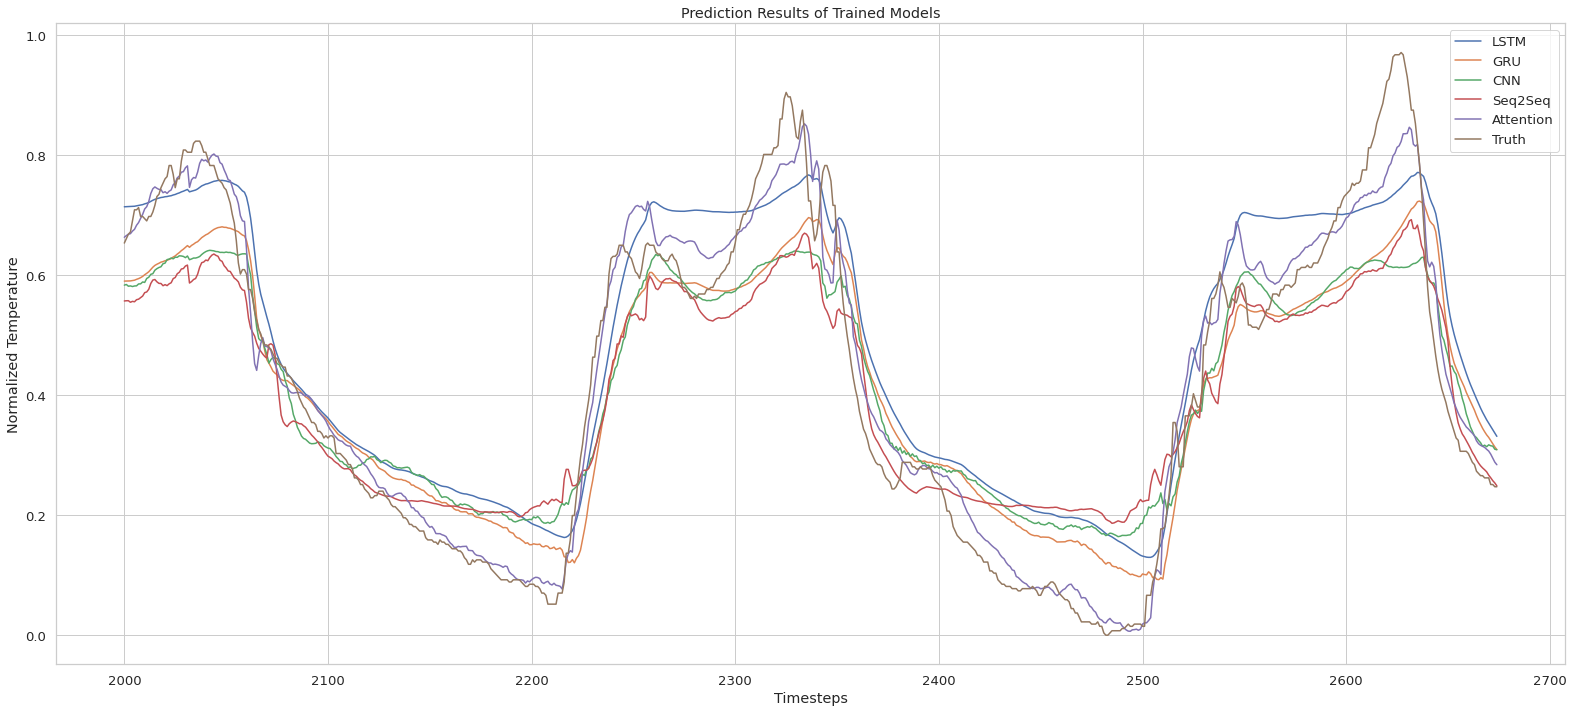

In [75]:
fig, ax1 = plt.subplots(1, 1, figsize=(22, 10))

predictions_df[2000:].plot(ax=ax1)
plt.title(label='Prediction Results of Trained Models')
plt.xlabel('Timesteps')
plt.ylabel('Normalized Temperature')
plt.tight_layout()

# Plot Forecast

In [127]:
expanded_end_date = '2019-04-14'

expanded_train=resampled[init_date : expanded_end_date]
expanded_train=scaler.transform(expanded_train)
expanded_train.shape

(12960, 3)

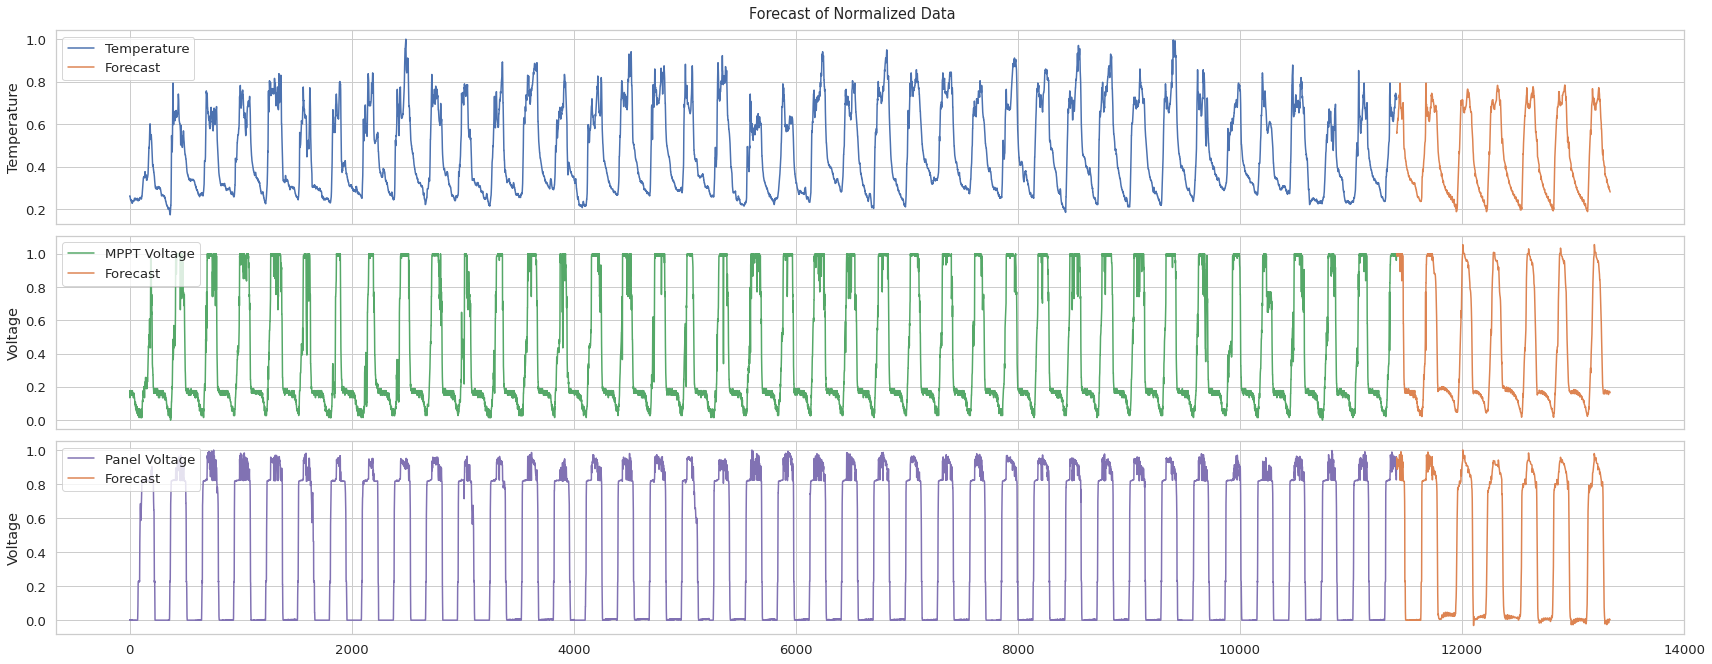

In [166]:
# first set of samples
forecast_range=100
palette = sns.color_palette('deep')

batch = train_X[-1, :, :]
predictions_forecast = batch
# future timesteps to forcast times X horizon timesteps
for i in range(forecast_range):
  one_step_pred = model_att.predict(batch.reshape(1, n_timesteps_in, n_features))
  batch = np.concatenate([batch[n_timesteps_out:], one_step_pred.reshape(n_timesteps_out, n_features)], axis=0)
  predictions_forecast = np.row_stack([predictions_forecast, one_step_pred.reshape(n_timesteps_out, n_features)])

fig, axx = plt.subplots(3, 1, figsize=(24,9), sharex=True)

fig.suptitle('Forecast of Normalized Data',y=1.02, fontsize=14.5)
forecast = np.concatenate([train_y[:, n_timesteps_out-1, :], predictions_forecast], axis=0)
forecast[:train_y.shape[0]] = None
axx[0].plot(train_y[:, 0, 0], color=palette[0], label='Temperature')
axx[0].plot(forecast[:,0], color=palette[1], label='Forecast')
axx[0].set_ylabel('Temperature'); axx[0].legend(loc='upper left')

axx[1].plot(train_y[:, 0, 1], color=palette[2], label='MPPT Voltage')
axx[1].plot(forecast[:,1], color=palette[1], label='Forecast')
axx[1].set_ylabel('Voltage'); axx[1].legend(loc='upper left')

axx[2].plot(train_y[:, 0, 2], color=palette[4], label='Panel Voltage')
axx[2].plot(forecast[:,2], color=palette[1], label='Forecast')
axx[2].set_ylabel('Voltage'); axx[2].legend(loc='upper left')
plt.tight_layout()

# Get Transmissions (Anomalies)

In [290]:
def plot_anomalies(predictions_df, threshold):
  MAE_df = pd.DataFrame(data=abs(predictions_df[['Truth']].values - predictions_df[['Attention']].values).mean(axis=1), columns=['MAE'])
  MAE_df['Transmitted'] = (MAE_df['MAE'] > threshold)
  percent_transmitted = (MAE_df['Transmitted'].sum()/MAE_df.shape[0])*100
  print(percent_transmitted)
  fig, ax1 = plt.subplots(1, 1, figsize=(22, 6))

  predictions_df['Attention'].plot(ax=ax1, label='Prediction')
  predictions_df['Truth'].plot(ax=ax1)
  sns.scatterplot(x=MAE_df[MAE_df['Transmitted']==True].index, y=predictions_df.loc[MAE_df[MAE_df['Transmitted']==True].index]['Truth'], color='darkred', label='Outlier')
  plt.title(label='Transmitted Data in Testing Dataset')
  plt.xlabel('Timesteps')
  plt.ylabel('Normalized Temperature')
  plt.tight_layout()

  return MAE_df

2.1682242990654204


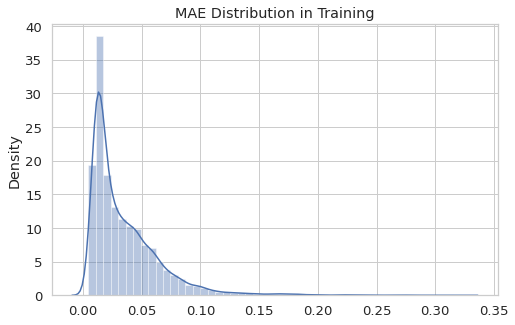

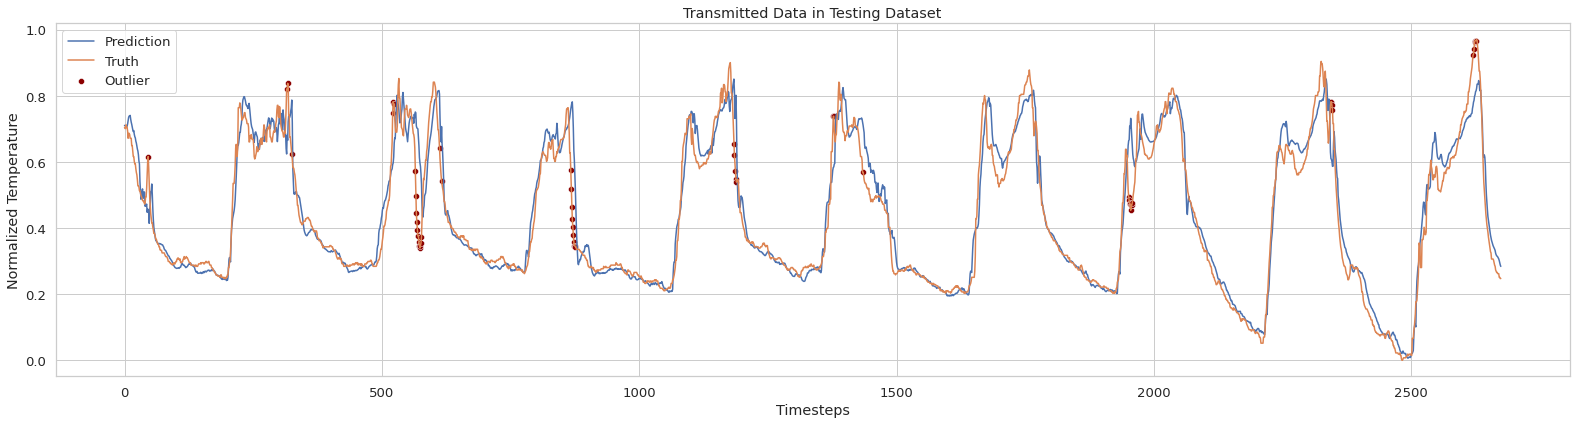

In [291]:
plt.figure(figsize=(8,5))
plt.title('MAE Distribution in Training')
sns.distplot(a=mae_overall_train)
threshold = 0.15

MAE_df = plot_anomalies(predictions_df, threshold)

Data summarization provides a convenient way to describe all of the values in a data sample with just a few statistical values.

The mean and standard deviation are used to summarize data with a Gaussian distribution, but may not be meaningful, or could even be misleading, if your data sample has a non-Gaussian distribution.

The most common example of data summarization is the calculation of the mean and standard deviation for data that has a Gaussian distribution. With these two parameters alone, you can understand and re-create the distribution of the data. The data summary can compress as few as tens or as many as millions individual observations.

The problem is, you cannot easily calculate the mean and standard deviation of data that does not have a Gaussian distribution. Technically, you can calculate these quantities, but they do not summarize the data distribution; in fact, they can be very misleading.

In the case of data that does not have a Gaussian distribution, you can summarize the data sample using the five-number summary.

The five-number summary involves the calculation of 5 summary statistical quantities: namely:

- Median: The middle value in the sample, also called the 50th percentile or the 2nd quartile.
- 1st Quartile: The 25th percentile. 
- 3rd Quartile: The 75th percentile.
- Minimum: The smallest observation in the sample.
- Maximum: The largest observation in the sample.

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short. The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots. On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots. We can calculate the percentiles of a dataset using the percentile() NumPy function that takes the dataset and specification of the desired percentile. The IQR can then be calculated as the difference between the 75th and 25th percentiles.

In [274]:
quartiles = np.percentile(mae_overall_train, [25, 50, 75])
# calculate min/max
data_min, data_max = mae_overall_train.min(), mae_overall_train.max()

print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)

Min: 0.005
Q1: 0.014
Median: 0.025
Q3: 0.048
Max: 0.322


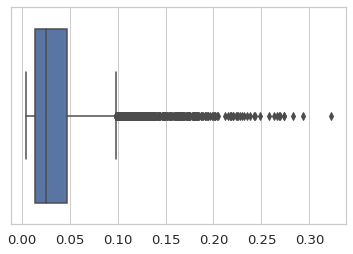

In [280]:
sns.boxplot(mae_overall_train)

In [281]:
quartiles[2]*2

0.09500656391566936